# <u> Detecting Kermit the Frog (Audio) </u>

# Creating features

## Convert and extract raw data

In [1]:
import subprocess
import librosa

# create .wav files using
# $ ffmpeg -i data/EPISODE.avi -ab 160k -ac 2 -ar 44100 -vn TARGET.wav

raw, sample_rate = librosa.load("../data/ep1_audio.wav")
raw.shape, sample_rate

((34107999,), 22050)

In [2]:
import pandas as pd

# load ground truth
truth_csv = pd.read_csv('../data/gt/gt_02_01_01.csv')
truth = truth_csv.kermit_audio
truth.shape

(1560,)

In [3]:
# get second or timeframe from raw waveform
def sec(sec, raw_wave=raw, sr=22050):
    if type(sec) == int:
        return raw_wave[sec*sr:(sec+1)*sr]
    elif type(sec) == list and len(sec) == 1:
        return raw_wave[sec[0]*sr:(sec[0]+1)*sr]
    elif type(sec) == list and len(sec) == 2:
        return raw_wave[sec[0]*sr:(sec[1]+1)*sr]

## Create Train Features

In [4]:
import statistics as stat
import numpy as np

def max_mfcc(wave_form, sr=22050):
    features = []
    for i in range(round(len(wave_form)/sr)):
        mfcc = librosa.feature.mfcc(sec(i, wave_form))
        # pick maximal value for each DCT dimension
        features.append([max(dim) for dim in mfcc])
    return features

def all_mfcc(wave_form, sr=22050, flat=False):
    features = []
    for i in range(round(len(wave_form)/sr)):
        mfcc = librosa.feature.mfcc(sec(i, wave_form))
        d_mfcc = librosa.feature.delta(mfcc)
        d2_mfcc = librosa.feature.delta(d_mfcc, order=2)

        features.append(np.concatenate((mfcc, d_mfcc, d2_mfcc), axis=0))
    
    # complete last entry
    fulld = features[0].shape[1]
    fill = fulld - features[-1].shape[1]
    features[-1] = np.concatenate((features[-1],np.zeros((features[0].shape[0],fill))), axis=1)
    
    # stack all of them on top of each other
    features = np.stack(features)
    
    if flat:
        nsamples, nx, ny = features.shape
        return features.reshape((nsamples,nx*ny))
    else:
        return features
    
features = all_mfcc(raw, flat=True)
features.shape

(1547, 2640)

## Create Test Features

In [5]:
# extract features
test_raw, test_sr = librosa.load('../data/ep2_audio.wav')
test_features = all_mfcc(test_raw, flat=True)
test_features.shape

(1548, 2640)

## Create Val Features

In [6]:
# extract val features
val_raw, val_sr = librosa.load('../data/ep3_audio.wav')
val_features = all_mfcc(val_raw, flat=True)
val_features.shape

(1539, 2640)

## Persist

In [7]:
# persist mfcc data
np.savetxt("../data/ep1_flat_mfcc.csv", features, delimiter=",")
np.savetxt("../data/ep2_flat_mfcc.csv", test_features, delimiter=",")
np.savetxt("../data/ep3_flat_mfcc.csv", val_features, delimiter=",")

# Train a model

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

### prepare data

In [9]:
# LOAD
ep1_data = pd.read_csv('../data/ep1_flat_mfcc.csv', sep=',', dtype=np.float64)
ep1_target = pd.read_csv('../data/gt/gt_02_01_01.csv', sep=',')[:len(ep1_data)].kermit_audio
ep2_data = pd.read_csv('../data/ep2_flat_mfcc.csv', sep=',', dtype=np.float64)
ep2_target = pd.read_csv('../data/gt/gt_02_04_04.csv.csv', na_values=[None, ' ', '']).fillna(0).head(len(ep2_data)).kermit_audio
ep3_data = pd.read_csv('../data/ep3_flat_mfcc.csv', sep=',', dtype=np.float64)
ep3_target = pd.read_csv('../data/gt/gt_03_04_03.csv', sep=',')[:len(ep3_data)].kermit_audio

# MERGE
X = pd.concat([ep1_data, ep2_data, ep3_data])
Y = pd.concat([ep1_target, ep2_target, ep3_target])

# SPLIT
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

### train TPOT model

In [10]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

# using the tpot model found in audio_TPOT.ipynb
pipe = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=1.0, min_samples_leaf=7, min_samples_split=11, n_estimators=100)

# Fix random state in exported estimator
if hasattr(pipe, 'random_state'):
    setattr(pipe, 'random_state', 42)

pipe.fit(x_train, y_train)

CPU times: user 38.5 s, sys: 8.83 ms, total: 38.5 s
Wall time: 38.5 s


ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_features=1.0,
                     min_samples_leaf=7, min_samples_split=11, random_state=42)

### evaluate

Accuracy:   0.943
Precision:  1.0
Recall:     0.4106
F1:         0.5822


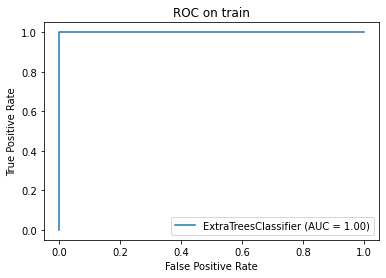

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve

# EVAL
tpreds = pipe.predict(x_train)

print("Accuracy:  ", round(accuracy_score(y_train, tpreds),4) )
print("Precision: ", round(precision_score(y_train, tpreds),4) )
print("Recall:    ", round(recall_score(y_train, tpreds),4) )
print("F1:        ", round(f1_score(y_train, tpreds),4) )

plot_roc_curve(pipe, x_train, y_train)
plt.title("ROC on train")
plt.show()

Accuracy:   0.9061
Precision:  1.0
Recall:     0.0225
F1:         0.044


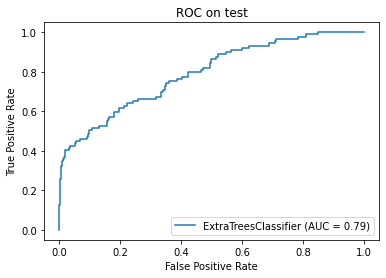

In [13]:
# EVAL
preds = pipe.predict(x_test)

print("Accuracy:  ", round(accuracy_score(y_test, preds),4) )
print("Precision: ", round(precision_score(y_test, preds),4) )
print("Recall:    ", round(recall_score(y_test, preds),4) )
print("F1:        ", round(f1_score(y_test, preds),4) )

plot_roc_curve(pipe, x_test, y_test)
plt.title("ROC on test")
plt.show()